# Genetics Application

For this set of questions, we will explore the use of Convolutional Neural Networks to solve a problem with Biological significance (don't worry, no background knowledge is expected). Every cell in your body contains Deoxyribonucleic acid (DNA), which is essentially the instructions for making all the proteins in your body. DNA can be thought of as a very long string where the alphabet is \{A,C,T,G\}.
The physical attributes of the DNA string and its characters are not important here, except that ~98% of our DNA is physically inaccessible to external molecules. Understanding which regions of DNA are accessible and why is of great interest to scientists. This motivates learning predictive models which could accurately classify such regions. In particular, we will be implementing the deep network called [Basset](https://pubmed.ncbi.nlm.nih.gov/27197224/).


In [1]:
#@title Mount your Google Drive
%matplotlib inline
%load_ext autoreload
%autoreload 2

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
#@title Link your assignment folder & install requirements
#@markdown Enter the path to the assignment folder in your Google Drive
import sys
import os
import shutil
import warnings

folder = "/content/gdrive/MyDrive/assignment_6135/assignment1" #@param {type:"string"}
!ln -Ts $folder /content/A1 2> /dev/null

# Add the assignment folder to Python path
if '/content/A1' not in sys.path:
    sys.path.insert(0, '/content/A1')

# Install requirements
!pip install -qr /content/A1/requirements.txt

# Check if CUDA is available
import torch
if not torch.cuda.is_available():
    warnings.warn('CUDA is not available.')

     |████████████████████████████████| 2.9 MB 5.8 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.


In [3]:
# unzip data
if not os.path.exists('/content/A1/er.h5'):
    os.system('unzip /content/A1/er.zip')
    os.system('mv /content/er.h5 /content/A1/er.h5')

## Running on GPU
In Google Colab, you can run your code on GPU. This will be particularly important in CNN part of the assignment. To make sure the notebook is running on GPU, you can change the notebook settings with
* (EN) `Edit > Notebook Settings`
* (FR) `Modifier > Paramètres du notebook`

Be mindful not to use the GPU if your code does not need to run on GPU.

In [4]:
import random

import numpy as np
import h5py
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

import solution

In [5]:
# The hyperparameters we will use
batch_size = 64
learning_rate = 0.002

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# set RNG
seed = 42
torch.backends.cudnn.deterministic = True
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if device.type=='cuda':
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

Let's build the dataset that we will be using. Before doing any machine learning, you should always inspect the data you will be using (especially when that data is uncommon)!

In our case, the input data are subsequences of DNA that come from the reference human genome HG19. HG19 can be thought of as the DNA of a prototypical human (but it does not come from any single person).
The input data is one-hot encoded, such that:

$$A = \begin{pmatrix} 1 \\ 0 \\ 0 \\ 0 \end{pmatrix}, C = \begin{pmatrix} 0 \\ 1 \\ 0 \\ 0 \end{pmatrix}, G = \begin{pmatrix} 0 \\ 0 \\ 1 \\ 0 \end{pmatrix}, T = \begin{pmatrix} 0 \\ 0 \\ 0 \\ 1 \end{pmatrix}$$

Each base-pair $\{A,C,G,T\}$ are concatenated along the length of the sequence. Each data point is equivalent to an image with a rectangular shape (sequence length, 4) and a single channel for data processing purposes.

The target data for our sequence are binary strings encoded as $1$ if the DNA subsequence is accessible and $0$ if it is not. This data was collected across experiments. For each sample, the target is a vector of size 164, with $1$s in the indices of the experiments where the DNA is accessible and $0$ otherwise.

# **Question 1 (Understanding the Data)** 
(10 points). You will notice that PyTorch is very object-oriented -- everything you use is the subclass of a PyTorch class. For datasets, we subclass `torch.utils.data.Dataset`.

1. Define the `__getitem__` and `__len__` methods for the `BassetDataset` class in `solution.py`
2. What is the length of each sequence we will feed into our model?  Make the `get_seq_len` method of the `BassetDataset` class to return it.
3. Is it true that each data point is also equivalent to an image with a rectangular shape (1, sequence length) with 4 channels? Write the method `is_equvalent` to return your answer (either return True or False).

Note: this data has already been pre-processed, so do not include any additional data transformations!

In [7]:
# investigate your data
f = h5py.File('/content/A1/er.h5', 'r')
f.keys()
f.close()

In [8]:
basset_dataset_train = solution.BassetDataset(path='/content/A1', f5name='er.h5', split='train')
basset_dataset_valid = solution.BassetDataset(path='/content/A1', f5name='er.h5', split='valid')
basset_dataset_test = solution.BassetDataset(path='/content/A1', f5name='er.h5', split='test')
basset_dataloader_train = DataLoader(basset_dataset_train,
                                     batch_size=batch_size,
                                     drop_last=True,
                                     shuffle=True,
                                     num_workers=1)
basset_dataloader_valid = DataLoader(basset_dataset_valid,
                                     batch_size=batch_size,
                                     drop_last=True,
                                     shuffle=False,
                                     num_workers=1)
basset_dataloader_test = DataLoader(basset_dataset_test,
                                    batch_size=batch_size,
                                    drop_last=True,
                                    shuffle=False,
                                    num_workers=1)

# **Question 2 (Building the Network)** 
(15 points). PyTorch also provides an abstraction for differentiable models: `torch.nn.Module`. In `solution.py`, we define Basset as a subclass of this class.

1. Fill in the missing values denoted as `?` within the class definition using [supplementary figure 13](https://genome.cshlp.org/content/suppl/2016/06/10/gr.200535.115.DC1/Supplementary_Figures.pdf) and convolution arithmetic.
2. Write the `forward` pass function. Again, please refer to [supplementary figure 13](https://genome.cshlp.org/content/suppl/2016/06/10/gr.200535.115.DC1/Supplementary_Figures.pdf).

  Do not include any output activation in your forward method! In practice, it is better to use a loss function that has the output activation built-in.

In [9]:
model = solution.Basset().to(device)
model.eval()

Basset(
  (drplayer): Dropout(p=0.3, inplace=False)
  (conv1): Conv2d(1, 300, kernel_size=(19, 4), stride=(1, 1), padding=(9, 0))
  (conv2): Conv2d(300, 200, kernel_size=(11, 1), stride=(1, 1), padding=(5, 0))
  (conv3): Conv2d(200, 200, kernel_size=(7, 1), stride=(1, 1), padding=(4, 0))
  (bn1): BatchNorm2d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool1): MaxPool2d(kernel_size=(3, 1), stride=(3, 1), padding=0, dilation=1, ceil_mode=False)
  (maxpool2): MaxPool2d(kernel_size=(4, 1), stride=(4, 1), padding=0, dilation=1, ceil_mode=False)
  (maxpool3): MaxPool2d(kernel_size=(4, 1), stride=(4, 1), padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2600, out_features=1000, bias=True)
  (bn4): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_s

# **Question 3 (Area Under the Curve)** 
(25 points). Each DNA sequence is either exposed (we'll call this the positive case) or not (we'll call this the negative case). The output of our model should be used to return a binary decision about the sequence.

For a given case, we say that our model made a positive prediction whenever its output value is above some threshold $k$, and a negative prediction otherwise.

Define the *True Positive Rate* (TPR) as the number of correctly prediced positive cases divided by the number of positive cases. Define the *False Positive Rate* (FPR) as the  number of cases that were incorrectly predicted as positive divided by the number of negative cases.

1. Complete the function `compute_fpr_tpr` in `solution.py`. This code will compute the TPR and FPR given your models decisions and the true targets.

2. Your FPR and TPR change as a function of $k$. Specifically, we can plot the FPR on the x-axis and the TPR on the y-axis for different values of $k$. The shape of the resulting curve (ROC curve) tells us something about our classifiers performance. We will explore via simulation what this plot looks like when our model is just making random guesses. In `solution.py`, fill in the function `compute_fpr_tpr_dumb_model`. This function will generate 1000 binary random variables to use as targets and 1000 uniform random variables between 0 and 1 as our model predictions. It will then compute the fpr and tpr for $k\in \{0, 0.05,..., 0.95\}$ You should plot what the ROC curves look like for your own knowledge.

In [ ]:
solution.compute_fpr_tpr_dumb_model()

{'fpr_list': [1.0,
  0.9540918163672655,
  0.9121756487025948,
  0.8562874251497006,
  0.782435129740519,
  0.7405189620758483,
  0.6946107784431138,
  0.6447105788423154,
  0.5948103792415169,
  0.5548902195608783,
  0.5109780439121756,
  0.45708582834331335,
  0.41317365269461076,
  0.34930139720558884,
  0.31137724550898205,
  0.25748502994011974,
  0.20758483033932135,
  0.15768463073852296,
  0.09780439121756487,
  0.043912175648702596],
 'tpr_list': [1.0,
  0.9378757515030061,
  0.8717434869739479,
  0.811623246492986,
  0.7675350701402806,
  0.7214428857715431,
  0.6673346693386774,
  0.625250501002004,
  0.56312625250501,
  0.5230460921843687,
  0.48296593186372744,
  0.4248496993987976,
  0.36072144288577157,
  0.30861723446893785,
  0.26452905811623245,
  0.22845691382765532,
  0.1903807615230461,
  0.14829659318637275,
  0.10220440881763528,
  0.04809619238476954]}

3. We will now simulate a better model. In `solution.py`, fill in the function `compute_fpr_tpr_smart_model`. This will simulate 1000 targets the same way as before. However, this will simulate model outputs as uniform random variables between 0.4 and 1 for the positive cases. For the negative cases, simulate uniform random variables between 0 and 0.6. Compute the tpr and fpr varying $k$ like before. You should also look at the ROC curve.

In [ ]:
solution.compute_fpr_tpr_smart_model()

{'fpr_list': [1.0,
  0.9348739495798319,
  0.8445378151260504,
  0.7605042016806722,
  0.6743697478991597,
  0.592436974789916,
  0.5,
  0.4117647058823529,
  0.3487394957983193,
  0.26260504201680673,
  0.17016806722689076,
  0.07563025210084033,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 'tpr_list': [1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.8740458015267175,
  0.8129770992366412,
  0.7614503816793893,
  0.6679389312977099,
  0.5820610687022901,
  0.5038167938931297,
  0.42366412213740456,
  0.3320610687022901,
  0.25763358778625955,
  0.1717557251908397,
  0.08778625954198473]}

4. The Area Under the ROC Curve (AUC) summarizes the ROC plot as a single number. It is literally computed as the area under the the ROC curve (take the average of the left and right Reimann sums). Complete the function `utils.compute_auc`. Then, in `compute_auc_both_models`, recreate the dumb and smart models from parts 2 and 3 and compute the AUC of them.

In [ ]:
solution.compute_auc_both_models()

{'auc_dumb_model': 0.47503110111964025, 'auc_smart_model': 0.9443744374437444}

5. Complete the function `compute_auc_untrained_model`, which will compute the AUC of your untrained model.

    Note: since we are doing multi-task prediction, your model outputs and targets will have shape (Batch size, Num targets). Flatten these matrices so that they are two vectors, each of size Batch size * Num targets.
    Then, procede with AUC as if you were in the usual single task case...

In [ ]:
solution.compute_auc_untrained_model(model, basset_dataloader_test, device)

[0 0 0 ... 0 0 0] (11787008,)
[0.50072783 0.49764028 0.49931613 ... 0.5073963  0.49282667 0.5019716 ] (11787008,)


{'auc': 0.5067502226401547}

# **Question 4 (Training the Network)**
(20 points) We will now write the training loop for Basset.

1. Notice that for each input, we have one target per experiment, and each target is binary. Write the function `get_critereon`, which will pick the appropriate `loss` function. 

  Hint: you may consult the [relevant PyTorch documentation](https://pytorch.org/docs/stable/nn.html#loss-functions)



In [10]:
criterion = solution.get_critereon()

2. Finish the training loop by filling in the missing code for the `train_loop`  pass and `valid_loop` functions in `solution.py.`

    Both loops must return the loss and AUC (computed the same way as the previous question). They must be returned by each function (see the docstring for more details).

In [ ]:
optimizer = optim.Adam(list(model.parameters()), lr=learning_rate, betas=(0.9, 0.999))

valid_score_best = 0
patience = 2
num_epochs = 5  # you don't need to train this for that long!

for e in range(num_epochs):
    train_score, train_loss = solution.train_loop(model, basset_dataloader_train, device, optimizer, criterion)
    valid_score, valid_loss = solution.valid_loop(model, basset_dataloader_valid, device, optimizer, criterion)

    print('epoch {}: loss={:.3f} score={:.3f}'.format(e,
                                                      valid_loss,
                                                      valid_score))

    if valid_score > valid_score_best:
        print('Best score: {}. Saving model...'.format(valid_score))
        torch.save(model, 'model_params.pt')
        valid_score_best = valid_score
    else:
        patience -= 1
        print('Score did not improve! {} <= {}. Patience left: {}'.format(valid_score,
                                                                          valid_score_best,
                                                                          patience))
    if patience == 0:
        print('patience reduced to 0. Training Finished.')
        break

In [250]:
trained_model = solution.Basset()

In [251]:
trained_model.load_state_dict(torch.load('A1/model_params_2.pt').state_dict())

<All keys matched successfully>

In [252]:
trained_model = trained_model.to(device)

In [253]:
trained_model.eval()

Basset(
  (drplayer): Dropout(p=0.3, inplace=False)
  (conv1): Conv2d(1, 300, kernel_size=(19, 4), stride=(1, 1), padding=(9, 0))
  (conv2): Conv2d(300, 200, kernel_size=(11, 1), stride=(1, 1), padding=(5, 0))
  (conv3): Conv2d(200, 200, kernel_size=(7, 1), stride=(1, 1), padding=(4, 0))
  (bn1): BatchNorm2d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool1): MaxPool2d(kernel_size=(3, 1), stride=(3, 1), padding=0, dilation=1, ceil_mode=False)
  (maxpool2): MaxPool2d(kernel_size=(4, 1), stride=(4, 1), padding=0, dilation=1, ceil_mode=False)
  (maxpool3): MaxPool2d(kernel_size=(4, 1), stride=(4, 1), padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2600, out_features=1000, bias=True)
  (bn4): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_s

# **Question 5 (Interpreting the Model)**

(30 points) In real-world applications of deep learning, it is *crucial* that we verify that our models are learning what we expect them to learn. In this exercise, we will replicate a part of figure 3b from [Basset](https://pubmed.ncbi.nlm.nih.gov/27197224/).

In genetics, there exists well known DNA *motifs*: short sequences which appear throughtout our DNA, and whose function are well documented. We expect that the filters of the first convolution layer should learn to identify some of these motifs in order to solve this task.

**Please submit the answers to this exercise on a single paged PDF!**

1. First, we need to ensure that our model has learned something. Plot the ROC curve and compute the AUC of your model after training. Compare the ROC curves and the AUC before and after training with your simulated models. What do you notice?

2. We represent motifs as position weight matrices (PWMs). This is a matrix of size $4$ $\times$ the motif length, where the $(i,j)$th entry is a count of how often base-pair $i$ occurs at position $j$. Open the PWM for the CTCF motif, which can be found in `MA0139.1.jaspar`. Normalize this matrix so that each column sums to $1$. Display the PWM.

3. In the methods section of the [paper](https://pubmed.ncbi.nlm.nih.gov/27197224/) (page 998), the authors describe how they converted each of the $300$ filters into normalized PWMs. First, for each filter, they determined the maximum activated value across the *dataset* (you may use a subset of the test set here). Compute these values.


4. Next, they counted the base-pair occurrences in the set of sequences that activate the filter to a value that is more than half of its maximum value.

  Note: You should use `torch.functional.unfold`.

5. Given your 300 PWMs derived from your convolution filters, check to see if any of them are similar to the PWM for CTCF. You could quantify the similarity using *Pearson Correlation Coefficient*. Make a visualization of the PWM of the CTCF motif along with the most similar ones learned from the network. 

**A couple of points that may help you with this question**
* I've noticed that instances of Google Colab vary significantly in speed (probably the GPU you are assigned). If your code is running very slowly, you can restart it until you get a faster instance.
* You are free to change the scoring function when training (I use the same AUC but changed the increments of thresholds from 0.05 to 0.01 and found that the score increased more visibly).

In [254]:
#Compute Ytrue an Ypred
def compute_model_yvals(model, dataloader, device):
    """
    Computes the AUC of your input model

    Args:
        :param model: solution.Basset()
        :param dataloader: torch.utils.data.DataLoader
                           Where the dataset is solution.BassetDataset
        :param device: torch.device

    :Return: dict with key 'auc'.
             This contains the AUC for the model
             auc value should be float

    Notes:
    * Dont forget to re-apply your output activation!
    * Make sure this function works with arbitrarily small dataset sizes!
    * You should collect all the targets and model outputs and then compute AUC at the end
      (compute time should not be as much of a consideration here)
    """
    y_pred = []
    y_true = []
    model.to(device)
    model.eval()
    for x in dataloader:
        seq = x['sequence']
        target = x['target']
        y_true.append(torch.flatten(target).numpy())
    
        x = seq.to(device)
        y_hat = torch.sigmoid(model(x))
        # y_hat = model(y_hat)
        y_hat = torch.flatten(y_hat)
        y_hat = y_hat.cpu().detach().numpy()
        y_pred.append(y_hat)
    y_pred = np.array(np.concatenate( y_pred, axis=0 ))
    y_true = np.array(np.concatenate( y_true, axis=0), dtype = np.int32)
    y_pred = np.ravel(y_pred)
    y_true = np.ravel(y_true)
    # print(y_true, y_true.shape)
    # print(y_pred, y_pred.shape)
    output = (y_true,y_pred)
    auc = compute_auc_mod(y_true, y_pred)
    # WRITE CODE HERE

    return auc
def compute_auc_mod(y_true, y_model):
    """
    Computes area under the ROC curve (using method described in main.ipynb)
    Args:
        :param y_true: groundtruth labels (np.array of ints [0 or 1])
        :param y_model: model outputs (np.array of float32 in [0, 1])
    :Return: dict with key 'auc'.
             This contains the AUC for the model
             auc value should be float

    Note: if you set y_model as the output of solution.Basset, 
    you need to transform it before passing it here!
    """
    output = {'auc': 0.}
    fpr_list = []
    tpr_list = []

    for k in np.arange(0, 1, 0.05):
        y_pred =  np.where(y_model >= k, 1, 0)
        ratios = solution.compute_fpr_tpr(y_true, y_pred)
        fpr_list.append(ratios['fpr'])
        tpr_list.append(ratios['tpr'])
        
    # WRITE CODE HERE
    output['auc'] = -1 * np.trapz(tpr_list,fpr_list)
    output['tpr'] = tpr_list
    output['fpr'] = fpr_list

    return output

In [255]:
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

In [256]:
output_untrained = compute_model_yvals(model, basset_dataloader_test, device)

In [257]:
output_trained = compute_model_yvals(trained_model, basset_dataloader_test, device)

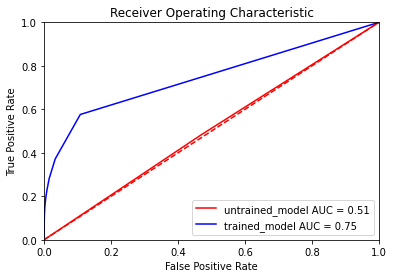

In [258]:
plt.title('Receiver Operating Characteristic')
plt.plot(output_untrained['fpr'], output_untrained['tpr'], 'b', label = 'untrained_model AUC = %0.2f' % output_untrained['auc'], color='red')
plt.plot(output_trained['fpr'], output_trained['tpr'], 'b', label = 'trained_model AUC = %0.2f' % output_trained['auc'])

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
solution.compute_auc_untrained_model(trained_model, basset_dataloader_test, device)

[0 0 0 ... 0 0 0] (11787008,)
[0.00365777 0.0102314  0.00819277 ... 0.00099646 0.00138345 0.00081916] (11787008,)


{'auc': 0.7474894211944998}

In [259]:
def q5_3(model, dataloader, device):
  # activation = {}
  # def get_activation(name):
  #   def hook(model, input, output):
  #       activation[name] = output.detach()
  #   return hook
  y_pred = []
  y_true = []
  model.to(device)
  model.eval()
  prev_max = None
  count = 0
  with torch.no_grad():
    trained_model.eval()
    for x in dataloader:
      seq = x['sequence']
      target = x['target']
      # y_true.append(torch.flatten(target).numpy())
      x = seq.to(device)
      # model.conv1.register_forward_hook(get_activation('conv1'))
      output = trained_model.conv1(x)
      vals = torch.amax(output, dim=(2,0))
      vals = torch.flatten(vals)
      if prev_max!=None:
        prev_max = torch.max(prev_max,vals)
      else:
        prev_max = vals
    # print(prev_max)
  return prev_max.detach().to('cpu')

In [213]:
from tqdm import tqdm

In [260]:
max_act_mat = -100 * torch.ones(300)
with torch.no_grad():
  trained_model.eval()
  for _,batch in enumerate(tqdm(basset_dataloader_test)):
    batch_x=batch["sequence"].to(device)
    output = trained_model.conv1(batch_x)
    for i in range (300):
      max_act_mat[i]= np.maximum(max_act_mat[i],torch.max(output[:,i,:,0]).cpu().detach().numpy())

100%|██████████| 1123/1123 [01:35<00:00, 11.77it/s]


In [200]:
filter_max = q5_3(trained_model, basset_dataloader_test, device)

In [262]:
max(max_act_mat)

tensor(4.5906)

In [ ]:
# unfold_seq = unfold(x_s)
#   N,_,L = unfold_seq.shape
#   unfold_seq = unfold_seq.reshape(N, 19, 4 ,L)
#   output = trained_model.conv1(x_s)
#   unfold_seq= unfold_seq.permute(0, 3, 1, 2).flatten(0, 1)
#   output = output.squeeze().permute (0, 2, 1).flatten (0, 1)
#   threshold = filter_max.unsqueeze(0).repeat(output.shape[0], 1)
#   threshold = threshold/2
#   mask = torch.gt(output.cpu (), threshold)
#   for i in range(300):
#     idx= mask [:, i]
#     seq_set= unfold_seq[idx]
#     pwm_i=seq_set.sum(dim=0)
#     pwm[1, ...]+=pwm_i.cpu()


In [202]:
half_filter_val = filter_max/2

In [203]:
max(half_filter_val)

tensor(2.2953)

In [158]:
import copy
hf_new = copy.deepcopy(half_filter_val).reshape(1,300,1).to(device)

In [263]:
pwm = torch.zeros(300, 19, 4)
unfold = torch.nn.Unfold(kernel_size=(19,4), padding=(9,0), stride=1)
count = 0
with torch.no_grad():
  trained_model.eval()
  for x in basset_dataloader_test:
    x_s = x['sequence'].to(device)
    # a = torch.reshape(torch.nn.functional.unfold(x_s,kernel_size=(19,4)),shape=(-1,1,19,4))
    # b = torch.nn.functional.conv2d(a, trained_model.conv1.weight, bias=trained_model.conv1.bias, padding=(0,0))
    # b = torch.flatten(b,2,3)
    # mask = torch.greater_equal(b,hf_new)
    unfold_seq = unfold(x_s)
    N,_,L = unfold_seq.shape
    unfold_seq = unfold_seq.reshape(N, 19, 4 ,L)
    output = trained_model.conv1(x_s)
    unfold_seq= unfold_seq.permute(0, 3, 1, 2).flatten(0, 1)
    output = output.squeeze().permute(0, 2, 1).flatten(0, 1)
    threshold = max_act_mat.unsqueeze(0).repeat(output.shape[0], 1)
    threshold = threshold/2
    mask = torch.gt(output.cpu(), threshold)
    for i in range(300):
      idx= mask [:, i]
      seq_set= unfold_seq[idx]
      pwm_i=seq_set.sum(dim=0)
      pwm[i, ...]+=pwm_i.cpu()
  # for i in range(300):
  #   idx = mask[:,i]
  #   seq_set = a[idx]
  #   pwm_i=seq_set.sum(dim=0)
  #   pwm[i, ...]+=pwm_i.cpu()
  # print(mask.shape)
  # print(sum(mask[:,1,0]==True))
  



In [272]:
pwm.shape

AttributeError: ignored

In [271]:
pwm[0]

(0.09529025191675794,
 0.1829134720700986,
 0.307776560788609,
 0.06133625410733844,
 0.008762322015334063,
 0.8148959474260679,
 0.04381161007667032,
 0.11732456140350878,
 0.9331140350877193,
 0.005488474204171241,
 0.36553238199780463,
 0.059275521405049394,
 0.013186813186813187,
 0.06153846153846154,
 0.11441144114411442,
 0.40924092409240925,
 0.09030837004405286,
 0.1288546255506608,
 0.44273127753303965)

In [245]:
#normalize the pwm
print(pwm.shape)
sum_pwm = pwm.sum(dim=2)
print(sum_pwm.shape)
norm_pwm = pwm/sum_pwm[:,:,None]
norm_pwm=norm_pwm.cpu().numpy()

torch.Size([300, 19, 4])
torch.Size([300, 19])


In [275]:
sum_pwm.shape

torch.Size([300, 19])

In [66]:
!pip install biopython

     |████████████████████████████████| 2.3 MB 5.3 MB/s 


In [83]:
from Bio import motifs
from Bio.Seq import Seq
import scipy

In [70]:
with open("A1/MA0139.1.jaspar") as handle:
  record = motifs.parse(handle, 'jaspar')

In [72]:
print(record[0])

TF name	CTCF
Matrix ID	MA0139.1
Matrix:
        0      1      2      3      4      5      6      7      8      9     10     11     12     13     14     15     16     17     18
A:  87.00 167.00 281.00  56.00   8.00 744.00  40.00 107.00 851.00   5.00 333.00  54.00  12.00  56.00 104.00 372.00  82.00 117.00 402.00
C: 291.00 145.00  49.00 800.00 903.00  13.00 528.00 433.00  11.00   0.00   3.00  12.00   0.00   8.00 733.00  13.00 482.00 322.00 181.00
G:  76.00 414.00 449.00  21.00   0.00  65.00 334.00  48.00  32.00 903.00 566.00 504.00 890.00 775.00   5.00 507.00 307.00  73.00 266.00
T: 459.00 187.00 134.00  36.00   2.00  91.00  11.00 324.00  18.00   3.00   9.00 341.00   8.00  71.00  67.00  17.00  37.00 396.00  59.00





In [73]:
mot = record[0]

In [264]:
ctcf_pwm_matrix= []
keys = []
pwm = mot.pwm
for k in pwm.keys():
    ctcf_pwm_matrix.append(np.array(list(pwm[k])))
    keys.append(k)
ctcf_pwm_matrix = np.array(ctcf_pwm_matrix)

In [265]:
ctcf_pwm_matrix

array([[0.09529025, 0.18291347, 0.30777656, 0.06133625, 0.00876232,
        0.81489595, 0.04381161, 0.11732456, 0.93311404, 0.00548847,
        0.36553238, 0.05927552, 0.01318681, 0.06153846, 0.11441144,
        0.40924092, 0.09030837, 0.12885463, 0.44273128],
       [0.31872946, 0.15881709, 0.05366922, 0.8762322 , 0.9890471 ,
        0.01423877, 0.57831325, 0.4747807 , 0.0120614 , 0.        ,
        0.00329308, 0.01317234, 0.        , 0.00879121, 0.80638064,
        0.01430143, 0.530837  , 0.35462555, 0.19933921],
       [0.08324206, 0.45345016, 0.49178532, 0.0230011 , 0.        ,
        0.07119387, 0.36582694, 0.05263158, 0.03508772, 0.99121844,
        0.62129528, 0.5532382 , 0.97802198, 0.85164835, 0.00550055,
        0.55775578, 0.33810573, 0.08039648, 0.29295154],
       [0.50273823, 0.20481928, 0.14676889, 0.03943045, 0.00219058,
        0.09967141, 0.01204819, 0.35526316, 0.01973684, 0.00329308,
        0.00987925, 0.37431394, 0.00879121, 0.07802198, 0.07370737,
        0.018

In [225]:
def corr2_coeff(A, B):
    # Rowwise mean of input arrays & subtract from input arrays themeselves
    A_mA = A - A.mean(1)[:, None]
    B_mB = B - B.mean(1)[:, None]

    # Sum of squares across rows
    ssA = (A_mA**2).sum(1)
    ssB = (B_mB**2).sum(1)

    # Finally get corr coeff
    return np.dot(A_mA, B_mB.T) / np.sqrt(np.dot(ssA[:, None],ssB[None]))

In [266]:
corr = []
for i in range(300):
  corr.append(scipy.stats.pearsonr(np.ndarray.flatten(ctcf_pwm_matrix), np.ndarray.flatten(norm_pwm[i])))

In [267]:
corr = np.array(corr)

In [268]:
np.max(corr[:,0])

0.26340639143648464

In [269]:
sorted = np.sort(arr)

In [270]:
sorted

array([-2.58928535e-01, -2.45249107e-01, -2.36409083e-01, -2.34413993e-01,
       -2.27515377e-01, -2.20560069e-01, -2.18713963e-01, -2.18148172e-01,
       -2.17495554e-01, -2.08425901e-01, -2.07649750e-01, -2.02405481e-01,
       -1.96571000e-01, -1.94087003e-01, -1.92597658e-01, -1.89750296e-01,
       -1.87110542e-01, -1.85871866e-01, -1.85114725e-01, -1.82779359e-01,
       -1.81143477e-01, -1.79485081e-01, -1.76455324e-01, -1.72343871e-01,
       -1.67027611e-01, -1.66726292e-01, -1.64970157e-01, -1.55658262e-01,
       -1.55168429e-01, -1.53552306e-01, -1.52434260e-01, -1.51903798e-01,
       -1.51155693e-01, -1.47457297e-01, -1.45745289e-01, -1.42622582e-01,
       -1.42522943e-01, -1.41573539e-01, -1.40157728e-01, -1.36915650e-01,
       -1.36907108e-01, -1.30025726e-01, -1.29930094e-01, -1.29214123e-01,
       -1.27720699e-01, -1.27350193e-01, -1.26821968e-01, -1.24119537e-01,
       -1.21583295e-01, -1.21160096e-01, -1.17292700e-01, -1.17078811e-01,
       -1.16134891e-01, -